Author: Lijing Wang (lijing52@stanford.edu), 2022

In [1]:
# load necessary modules
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')

from numpy.random import uniform as uniform
from scipy.stats import norm
import geostatspy.geostats as geostats 

from methods.non_stationary_2D import *
from utils.trend_RBF import *
from utils.GStatSim import *

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

plt.rcParams.update({'font.size': 15})

# Load data

In [2]:
# Load data
## 1. Radar/bed
radar = np.loadtxt('../data/Greenland_DigitalElevationModel/sample_region_radar_data.csv', delimiter=',',skiprows=1)
## 2. Surface
surface = np.loadtxt('../data/Greenland_DigitalElevationModel/sample_region_surface_data.csv', delimiter=',',skiprows=1)

Text(0, 0.5, 'Y (m)')

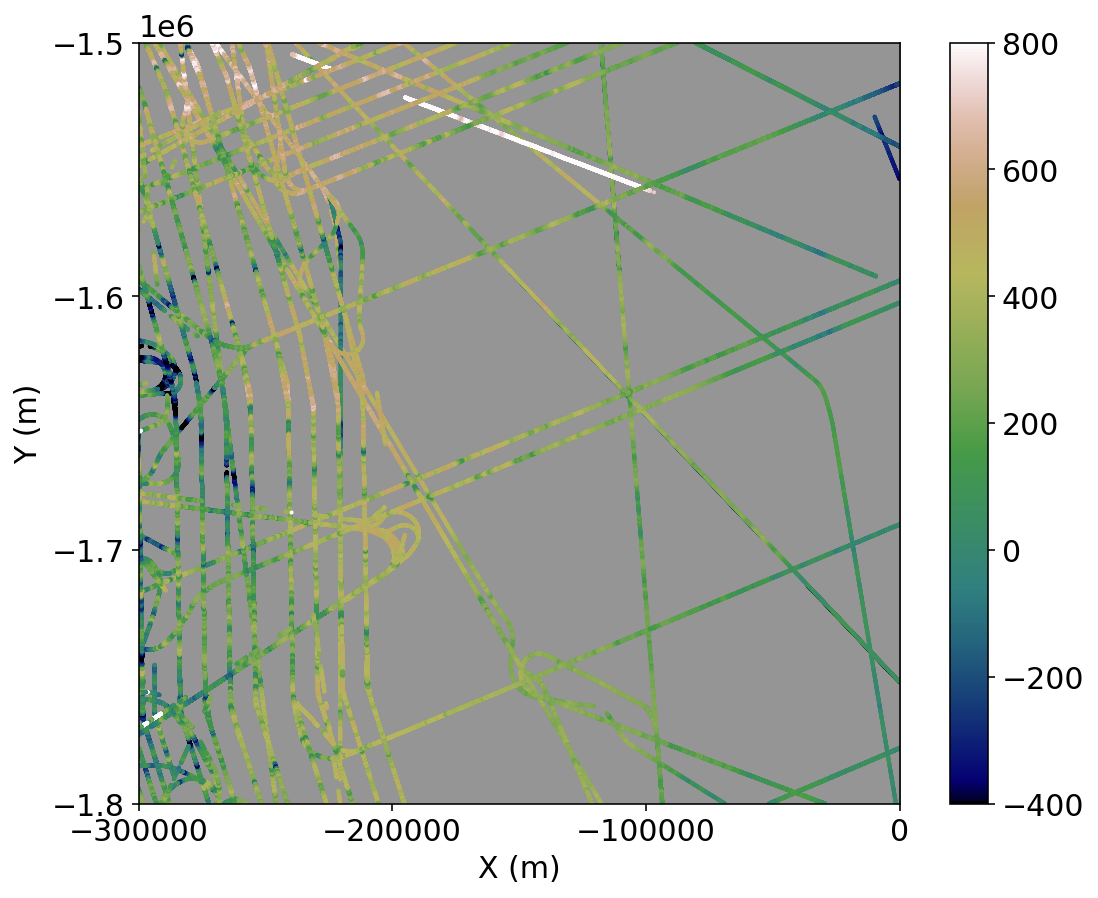

In [3]:
fig, ax = plt.subplots(figsize = (9,7)) 
plt.locator_params(nbins=4)
plt.imshow(np.zeros((1,1)),extent = [-300000,0,-1.8e6, -1.5e6],cmap = 'Greys',vmin = -1, vmax = 1)
sc = plt.scatter(x = radar[:,0],y = radar[:,1], c = radar[:,2], s = 1,  cmap='gist_earth',vmin = -400,vmax = 800)
plt.colorbar(sc)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

## Resolution and data grid

In [4]:
origin = np.array([-300000,-1800000])
resolution = np.array([2000,2000])
num_of_grids = np.array(300000/resolution+1,dtype = 'int64')

resize_data = np.copy(radar)
resize_data[:,:2] = np.round((resize_data[:,:2]-origin)/resolution)

data = np.zeros((num_of_grids[0],num_of_grids[1]))
data[:] = np.nan

for i in range(radar.shape[0]):
    data[np.int(resize_data[i,1]),np.int(resize_data[i,0])] = radar[i,2]

In [5]:
num_x = num_of_grids[0]
num_y = num_of_grids[1]

x = np.arange(num_x)
y = np.arange(num_y)

# Trend estimation, RBF

- Impacted by outliers? If we have a large smooth factor, we can smooth out the outliers. But the outliers still contribute to the trend

- It will be extremely slow if we have very fine grids.

In [6]:
data_DF = np.array([np.where(~np.isnan(data))[1],np.where(~np.isnan(data))[0], data[~np.isnan(data)]])
data_DF = pd.DataFrame(data_DF.T, columns = ['X','Y','data'])

In [7]:
trend_rbf = trend_estimation_rbf(data_DF, x, y, smooth = 50)

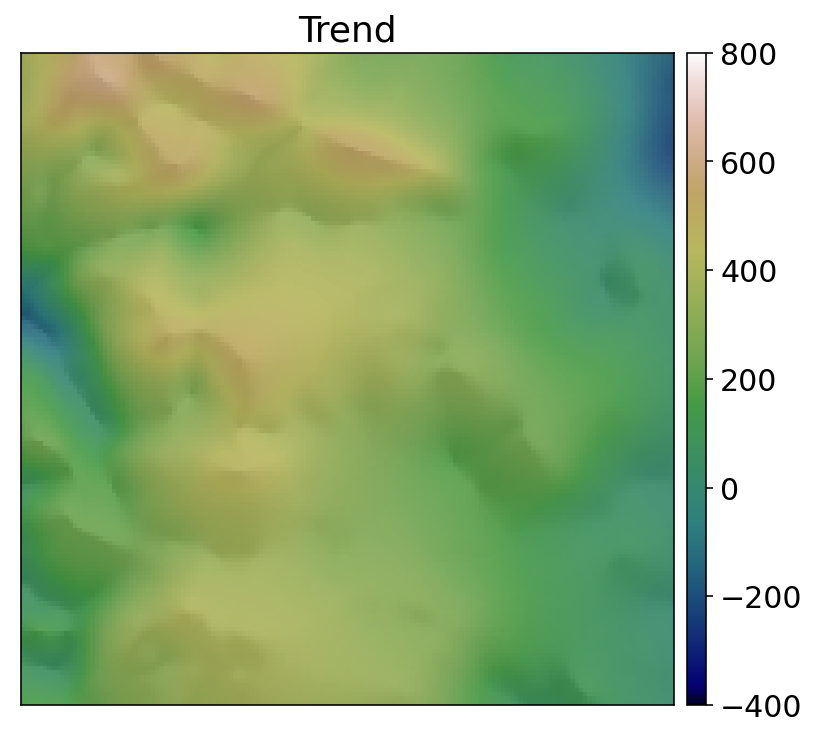

In [8]:
hillshade = es.hillshade(trend_rbf[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_rbf[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Trend",
    vmin = -400, vmax = 800,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Outlier detection
 If we plot a quantile-quantile plot for a residual vs Guassian distribution the outlier will deviate from that straight line.  

In [9]:
data_idx = ~np.isnan(data)
norm_quantile,residual,deviation,threshold,outlier_matrix = residual_quantile(trend_rbf, 
                                                                              data, 
                                                                              data_idx,outlier_proportion = 0.04)

Text(0.5, 1.0, 'QQ plot of residual')

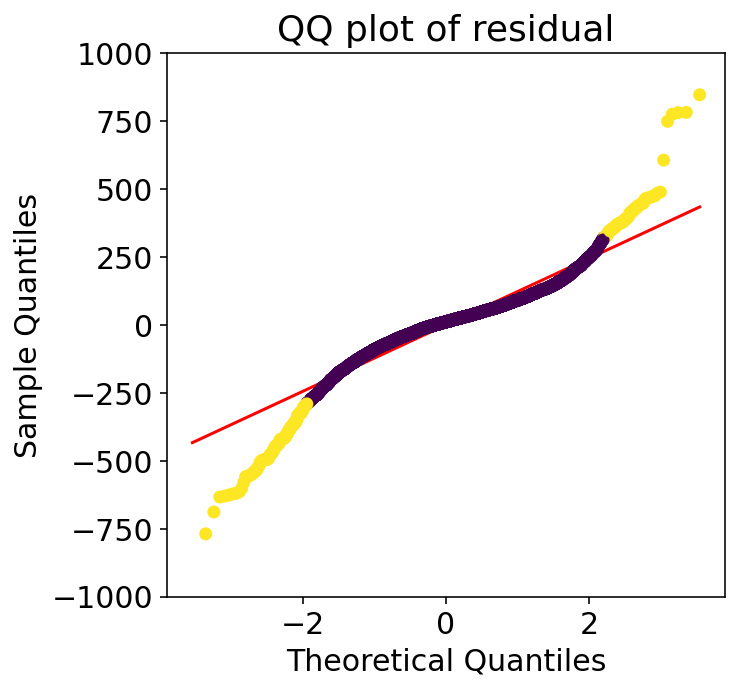

In [10]:
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (5, 5) 
fig = sm.qqplot(residual, line="r",marker = ".",ms = 0.01)
plt.scatter(norm_quantile,residual,c= (deviation>threshold)*1,zorder = 1000,s = 30)
plt.ylim(-1000,1000)
plt.xlim(-3.9,3.9)
plt.title('QQ plot of residual')

In [11]:
data[outlier_matrix==1] = np.nan

Text(0, 0.5, 'Y (m)')

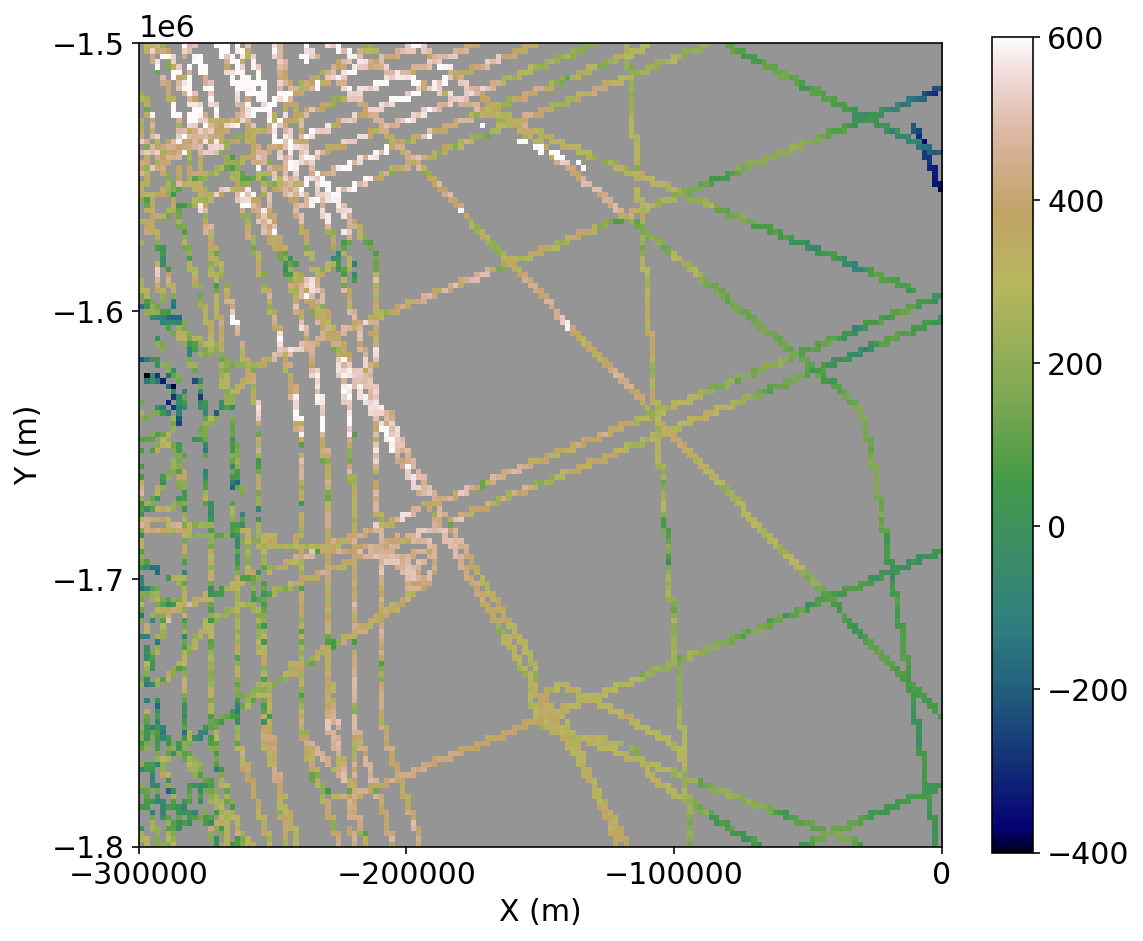

In [12]:
fig, ax = plt.subplots(figsize = (9,7.5)) 
plt.locator_params(nbins=4)
plt.imshow(np.zeros((1,1)),extent = [-300000,0,-1.8e6, -1.5e6],cmap = 'Greys',vmin = -1, vmax = 1)
plt.imshow(data,origin = 'lower',vmin = -400,vmax = 600,extent = [-300000,0,-1.8e6, -1.5e6], cmap = 'gist_earth')
plt.colorbar()
#plt.axis('off')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

In [14]:
data_DF = np.array([np.where(~np.isnan(data))[1],np.where(~np.isnan(data))[0], data[~np.isnan(data)]])
data_DF = pd.DataFrame(data_DF.T, columns = ['X','Y','data'])
trend_rbf = trend_estimation_rbf(data_DF, x, y, smooth = 500)

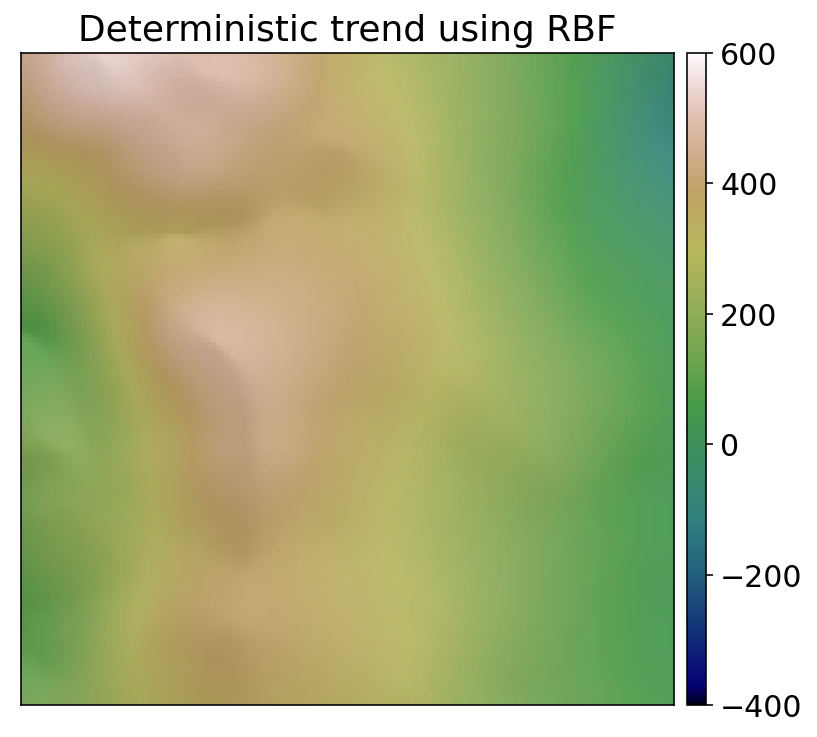

In [15]:
hillshade = es.hillshade(trend_rbf[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_rbf[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Deterministic trend using RBF",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In [ ]:
# np.save('../data/Greenland_DigitalElevationModel/trend_rbf.npy',trend_rbf)

# Trend estimation, McMC

In [16]:
# Initial trend, set as the mean 
trend_init = np.zeros(data.shape)
trend_init[:] = np.nanmean(data)

loss_prev = loss_function_hard_data(trend_init,data,data_idx)

In [ ]:
[trend_cache, loss_cache] = non_stationary_2D(trend_init, data, loss_prev, x,y, range_min = [75,75],range_max = [75,75],
                                              high_step = 20,  
                                              sigma = 500, iter_num = 4000)

## Trace plot

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(loss_cache[:])
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
cut_off = 20000

In [ ]:
trendmean = np.mean(trend_cache[cut_off:,:,:],axis = 0)

hillshade = es.hillshade(trendmean[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trendmean[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Stochastic trend mean",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
trendvar = np.var(trend_cache[cut_off:,:,:],axis = 0)

plt.imshow(trendvar,origin = 'lower',cmap = 'gist_earth',vmin = 0,vmax = 2000)
plt.colorbar()
plt.imshow(data,origin = 'lower',vmin = 0,vmax = 0, cmap = 'gist_earth')

plt.title('Trend variance')

plt.axis('off')

In [ ]:
idx = 40000
hillshade = es.hillshade(trend_cache[idx,::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_cache[idx,::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Iteration: "+str(idx),
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Convergence test

In [ ]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

In [ ]:
iter_num = 50000
trend_cache_mean = np.mean(trend_cache.reshape(iter_num,-1),axis = 1)
trend_cache_std = np.std(trend_cache.reshape(iter_num,-1),axis = 1)

In [ ]:
Gelmen_Rubin_Diagnostic(trend_cache_mean[20000:35000],
                        trend_cache_mean[35000:50000],burn_in = 0,length = 15000)

In [ ]:
Gelmen_Rubin_Diagnostic(trend_cache_std[20000:35000],
                        trend_cache_std[35000:50000],burn_in = 0,length = 15000)

In [ ]:
fig, ax = plt.subplots(figsize = (9,7.5)) 
plt.imshow(trendmean,origin = 'lower',vmin = -400,vmax = 800,cmap = 'gist_earth',alpha = 1)
plt.imshow(data,origin = 'lower',vmin = -400,vmax = 800,cmap = 'gist_earth')
plt.colorbar()
plt.scatter(50,50,c = 'C2',s = 40)
plt.text(50+4,50,'loc1')
plt.scatter(125,20,c = 'C3',s = 40)
plt.text(125+4,20,'loc2')
plt.axis('off')
plt.title('Trend')

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(trend_cache_mean[:],label = 'field_mean')
plt.plot(trend_cache_std[:],label = 'field_std')
plt.plot(trend_cache[:,50,50],label = 'loc1')
plt.plot(trend_cache[:,20,125],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

## ACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(trend_cache[cut_off:,20,20],alpha = 1,
               lags = np.arange(trend_cache[cut_off:,:,:].shape[0]),
               bartlett_confint = False)

In [ ]:
from statsmodels.tsa.stattools import acf
acf_values = np.zeros((10001,len(x),len(y)))
for i in tqdm(range(len(x))):
    for j in range(len(y)):
        acf_values[:,i,j] = acf(trend_cache[cut_off:,i,j],nlags = 10000)

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6) 
plt.plot(np.mean(acf_values.reshape(10001,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 10000,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

## Acceptance rate

In [ ]:
iter_num = 50000
start = 20000
1-np.sum(loss_cache[(start+1):,0]-loss_cache[start:-1,0]==0)/(iter_num-start-1)

In [ ]:
### acceptance rate curve
acc_rate = np.zeros(iter_num)
acc_rate[:] = np.nan

for iteration in np.arange(1,iter_num):
    acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(np.arange(1,iter_num),acc_rate[1:])
plt.text(iter_num-2000, 0.2+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

## Multiple chains

In [ ]:
import multiprocessing
high_step = 20 
sigma = 500
iter_num = 50000
velocity_path = 'Greenland_velocity/Greenland_'

input_list = [[trend_init, data, loss_prev, x, y, [75,75], [75,75], high_step, sigma, iter_num, 0],
              [trend_init, data, loss_prev, x, y, [50,50], [50,50], high_step, sigma, iter_num, 1],
              [trend_init, data, loss_prev, x, y, [30,30], [30,30], high_step, sigma, iter_num, 2],
              [trend_init, data, loss_prev, x, y, [20,20], [20,20], high_step, sigma, iter_num, 3],
              [trend_init, data, loss_prev, x, y, [10,10], [10,10], high_step, sigma, iter_num, 4],
              [trend_init, data, loss_prev, x, y, [50,50], [75,75], high_step, sigma, iter_num, 5]]

# Trend estimation, McMC
# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 6)
    result = pool.map(mp_non_stationary_2D,input_list)
    pool.close()

## Test if the residual is Gaussian (using QQ-plot)

In [ ]:
residual = data-trendmean

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (6, 6) 
fig = sm.qqplot(residual[~np.isnan(residual)], stats.t, fit=True, line="r")
plt.show()

In [ ]:
plt.hist(residual[~np.isnan(residual)],bins = 30,density = True)
plt.xlabel('Residual value')
plt.ylabel('Probability density')
plt.xlim(-500,500)

# Variogram calculation

In [ ]:
residual_df = np.vstack([np.where(~np.isnan(residual))[1],np.where(~np.isnan(residual))[0],residual[~np.isnan(residual)],data[~np.isnan(residual)]]).T
residual_df = pd.DataFrame(residual_df,columns = ['X','Y','residual','data'])

In [ ]:
# normal score transformation
residual_df['ns_residual'],  vr, wt_ns = geostats.nscore(residual_df,'residual')
residual_df['ns_data'],  _, _ = geostats.nscore(residual_df,'data')

Variogram without trend removal

In [ ]:
# compute anisotropic variogram

tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 2.0 # lag distance interval (in meters)
lag_tol = 1.0 # lag tolerance
nlag = 50 # number of lag distances to use
bandh = 100 # no effect for isotropic variogram

azi_mat = np.linspace(0,180,4,endpoint=False)             # directions in azimuth to consider
atol = 22.5 # 11.25 degree tolerance
isill = 0 # no effect for normal score transformed data

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

# variogram
for iazi in range(0,len(azi_mat)):  # Loop over all directions to get variograms
    azi = azi_mat[iazi]
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(residual_df,'X','Y','data',
                                                            tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag[npp==0] = np.nan

plt.figure(figsize = [8,6])
# plot anistropic variograms
for i in range(len(azi_mat)):
    plt.plot(lag[i,::-1]*resolution[0]/1000,gamma[i,::-1],'.-',label = 'Azimuth '+str(np.int(azi_mat[i])))
plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Variograms')
plt.legend(loc='lower right')

Variogram **with** trend removal

In [ ]:
# compute anisotropic variogram
bandh = 100 # bandwidth tolerance
azi_mat = np.linspace(0,180,4,endpoint=False)           # directions in azimuth to consider
atol = 22.5 # 11.25 degree tolerance

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

# variogram
for iazi in range(0,len(azi_mat)):  # Loop over all directions to get variograms
    azi = azi_mat[iazi]
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(residual_df,'X','Y','residual',
                                                            tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag[npp==0] = np.nan

# plot anistropic variograms
plt.figure(figsize = [8,6])
for i in range(len(azi_mat)):
    plt.plot(lag[i,::-1]*resolution[0]/1000,gamma[i,::-1],'.-',label = 'Azimuth '+str(np.int(azi_mat[i])))
plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Variograms')
plt.legend(loc='lower right')
#plt.xlim(-1,100)

# Sequential Gaussian simulation

In [ ]:
num_x = num_of_grids[0]
num_y = num_of_grids[1]

# x, y range
x = range(num_x)
y = range(num_y)

xx,yy = np.meshgrid(x,y)
pred_grid_ = np.vstack([xx.reshape(-1),yy.reshape(-1)]).T

In [ ]:
Azimuth = 0 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 1 # variogram structures
vtype = 2 # exponential type (1 = spherical, 2 = exponential, 3 = Gaussian)
cc = 1#np.var(residual_df['residual']) # contribution for each structure
a_max = 12.5 # major range for each structure
a_min = 12.5  # minor range for each structure

vario = [Azimuth, nug, a_max, a_min,cc] # save variogram parameters as a list

## Stochastic trend

In [ ]:
interval = 300
simulations_num = np.int((iter_num-cut_off)/interval)

In [ ]:
k = 25
sgs_stochastic = np.zeros((simulations_num,num_x*num_y))
for i in range(simulations_num):
    residual = data-trend_cache[np.int(cut_off+i*interval),:,:] # using trend MCMC
    residual_df = np.vstack([np.where(~np.isnan(residual))[1],
                             np.where(~np.isnan(residual))[0],
                             residual[~np.isnan(residual)],
                             data[~np.isnan(residual)]]).T
    residual_df = pd.DataFrame(residual_df,columns = ['X','Y','residual','data'])
    sgs_stochastic[i,:] = skrige_SGS(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20) # simulate

In [ ]:
sgs_full = sgs_stochastic.reshape(simulations_num,num_x,num_y)+trend_cache[(cut_off+np.arange(simulations_num)*interval),:,:]

In [ ]:
plot_image = sgs_full[0,:,:]
hillshade = es.hillshade(plot_image[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    plot_image[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="SGS realization 1, trend MCMC",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In [ ]:
plot_image = np.mean(sgs_full,axis = 0)
hillshade = es.hillshade(plot_image[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    plot_image[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="SGS mean, trend MCMC",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (9,7.5)) 
plt.imshow(np.var(sgs_full,axis = 0).reshape(num_x,num_y),origin = 'lower',cmap = 'gist_earth',vmin = 0,vmax = 13000)
plt.axis('off')
plt.title('SGS variance, trend MCMC',fontsize = 20) 
plt.colorbar()

## Deterministic trend

In [ ]:
residual = data-trend_rbf
residual_df = np.vstack([np.where(~np.isnan(residual))[1],
                         np.where(~np.isnan(residual))[0],
                         residual[~np.isnan(residual)],
                         data[~np.isnan(residual)]]).T
residual_df = pd.DataFrame(residual_df,columns = ['X','Y','residual','data'])

In [ ]:
# Kriging result
sgs_mean,sgs_var = skrige(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20)

In [ ]:
# Simulation result
sgs_deterministic1 = skrige_SGS(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20) # simulate
sgs_deterministic2 = skrige_SGS(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20) # simulate

In [ ]:
plot_image = sgs_mean.reshape(num_x,num_y)+trend_rbf
hillshade = es.hillshade(plot_image[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    plot_image[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="SGS mean, trend rbf",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.imshow(sgs_var.reshape(num_x,num_y),origin = 'lower',cmap = 'gist_earth',vmin = 0,vmax = 13000)
plt.colorbar()

plt.title('SGS variance, trend rbf')

plt.axis('off')